### Reporting Statistics
---

Everything it needs to answer questions

In [1]:
import sys, os, json, copy, sklearn, shap
import pandas as pd
import numpy as np
import lightgbm as lgb
import pickle as pkl
from tqdm import tqdm
from smart_open import open
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict as ddict

sys.path.insert(1, "../../..")
from src.feature_selection import (
    get_top_k_features,
    get_monotone_dir,
    remove_corr_fts,
    get_feature_by_lgbm_importance,
    get_feature_shap_abs
)
from rdsutils.metrics import (
    get_binary_metrics,
    get_pred_reports
)

plt.style.use("seaborn")
%load_ext autoreload
%autoreload 2

In [2]:
local_artifact_path = "../../../artifacts/final_model/"

In [91]:
segment = "full"

seed = 42
artifact_path = "s3://sofi-data-science/jxu/pl-gen4/prescreen"
data_dir = "s3://sofi-data-science/jxu/pl-gen4/data_dump/pl-gen4-final-data/prescreen"
nr_to_consider = 100

with open(os.path.join(artifact_path, "config.json"), "r") as f:
    config = json.load(f)
    
with open(os.path.join(artifact_path, segment, "woe_dict.pkl"), "rb") as f:
    woe_dict = pkl.load(f)
    
with open(os.path.join(artifact_path, segment, "woe_json.json"), "r") as f:
    woe_json = json.load(f)
    
with open(os.path.join(artifact_path, segment, "mp_woe_imputer.pkl"), "rb") as f:
    imputer_state_dict = pkl.load(f)
    
with open(os.path.join(artifact_path, segment, "monotone_dict.json"), "r") as f:
    monotone_dict = json.load(f)
    
with open(config["models"]["prescreen"]["lgbm_bmk_imputed"], "rb") as f:
    lgbm_bmk = pkl.load(f)
    
with open(os.path.join(local_artifact_path, "models", "prescreen_model_hp.pkl"), "rb") as f:
    model = pkl.load(f)
    
# with open(os.path.join(local_artifact_path, "hyper_tune_obj.pkl"), "rb") as f:
#     hptune = pkl.load(f)
    
bmk_fts = lgbm_bmk.feature_name_.copy()

display(config.keys()) 

# training data
target = "target"
target_indeterminate = "indeterminate"
ri_weight = "weight_ri"
weight = "weight"

dict_keys(['data', 'meta', 'data_columns', 'model_params', 'model_features', 'impute_vals', 'monotone', 'models'])

In [11]:
df_unimp = pd.read_parquet(config["data"]["prescreen-v2"][f"df"])
df_unimp.shape

(4369879, 275)

In [12]:
%%time
train_df = pd.read_parquet(config["data"]["prescreen-v2"][f"train_df_imputed"],
                    ) # columns=cols)
valid_df = pd.read_parquet(config["data"]["prescreen-v2"][f"valid_df_imputed"],
                    ) # columns=cols)
test_df = pd.read_parquet(config["data"]["prescreen-v2"][f"test_df_imputed"],
                    ) # columns=cols)
train_df.shape, valid_df.shape, test_df.shape

CPU times: user 39.3 s, sys: 1min 53s, total: 2min 33s
Wall time: 55.6 s


((3277182, 275), (1101191, 275), (1150725, 275))

In [23]:
train_df[[weight, "ri_source"]].groupby("ri_source")[weight].sum().round(2)

ri_source
booked    196413.00
others    333389.73
proxy     282575.50
Name: weight, dtype: float64

In [25]:
# 25%
df_ = train_df[[weight, "ri_source"]].groupby("ri_source")[weight].sum()
df_ /= df_.sum()
df_.loc[["booked", "proxy", "others"]]

ri_source
booked    0.241775
proxy     0.347837
others    0.410387
Name: weight, dtype: float64

In [32]:
# 30%
df_ = train_df[[weight, "ri_source"]].copy()
df_["weight_exp"] = df_[weight] * 0.3
df_ = df_.groupby("ri_source")["weight_exp"].sum()
df_ /= df_.sum()
df_.loc[["booked", "proxy", "others"]]

ri_source
booked    0.241775
proxy     0.347837
others    0.410387
Name: weight_exp, dtype: float64

#### Model
---

In [92]:
final_params = model.get_params()
final_params


{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.006631163485490334,
 'max_depth': 8,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 2500,
 'n_jobs': -1,
 'num_leaves': 45,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'auc',
 'verbosity': -1,
 'early_stopping_rounds': None,
 'monotone_constraints': [-1,
  1,
  1,
  1,
  1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,
  1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1],
 'feature_pre_filter': False,
 'lambda_l1': 3.882047094083081,
 'lambda_l2': 8.355557408730407,
 'feature_fraction': 0.8692351699685861,
 'bagging_fraction': 0.8941003105420229,
 'min_data_in_leaf': 700,
 'verbose_eval': 100}

In [93]:
len(final_params["monotone_constraints"])

32

#### Feature Dict
---

In [80]:
pd.DataFrame({""})

,0
0,


In [94]:
dd_path = 's3://sofi-data-science/hpeng/pl-gen4/data_dump/data_dict/combined_dict.csv'
exp_ddict_updated = pd.read_csv(dd_path, index_col=0)

In [96]:
exp_ddict_updated["adverse actionable"]

0       NaN
1       NaN
2         Y
3         Y
4         Y
       ... 
5095    NaN
5096    NaN
5097    NaN
5098    NaN
5099    NaN
Name: adverse actionable, Length: 5100, dtype: object

In [117]:
ranking = pd.read_csv(os.path.join(artifact_path, segment, "ranking.csv"), index_col=0)
ranking.loc[model.feature_name_][["lgbm_shap_mc_full", "lgbm_shap_mc_full_r1", 
         "lgbm_shap_mc_full_r2"]]

,lgbm_shap_mc_full,lgbm_shap_mc_full_r1,lgbm_shap_mc_full_r2
p13_all7936,44,44,23
p13_iqz9425,92,92,100
p13_alj8120,13,13,13
p13_all7518,73,73,2930
p13_reh7120,8,8,6
p13_iqz9420,2,2,3
t11_tbca2526,10,10,10
p13_all7312,36,36,44
p13_rtr5520,43,43,30
p13_upl8320,62,62,71


#### Feature Correlation
---

In [7]:
# imp

In [ ]:
# unimputed

#### Hyper Tune
---

In [54]:
hptune

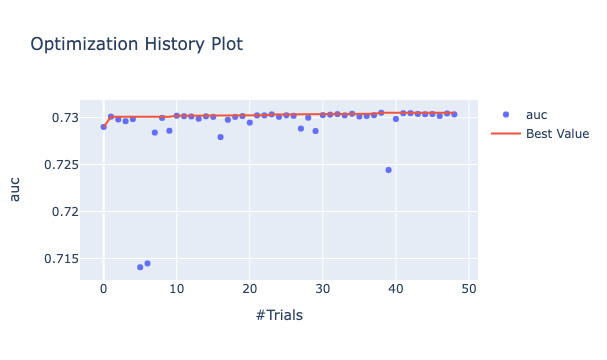

In [55]:
from optuna.visualization import plot_optimization_history
plot_optimization_history(hptune, target_name="auc")  # plotly - jupyterext

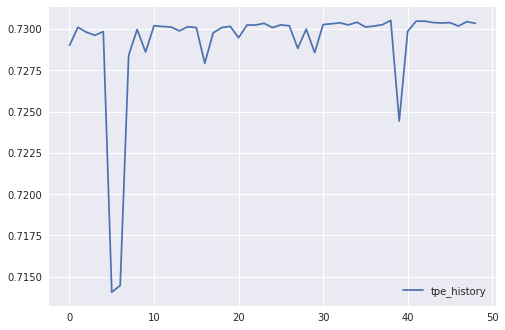

In [56]:
def get_trial_history(study):
    from optuna.trial import TrialState
    results = [trial.values for trial in study.trials if trial.state==TrialState.COMPLETE]
    results = [r[0] for r in results if isinstance(r, list)]
    return results

tpe_history = get_trial_history(hptune)
plt.plot(range(len(tpe_history)), tpe_history, label="tpe_history")
plt.legend()

In [57]:
hptune.best_params

{'n_estimators': 2500,
 'learning_rate': 0.006631163485490334,
 'num_leaves': 45,
 'max_depth': 8,
 'lambda_l1': 3.882047094083081,
 'lambda_l2': 8.355557408730407,
 'feature_fraction': 0.8692351699685861,
 'bagging_fraction': 0.8941003105420229,
 'min_data_in_leaf': 700}

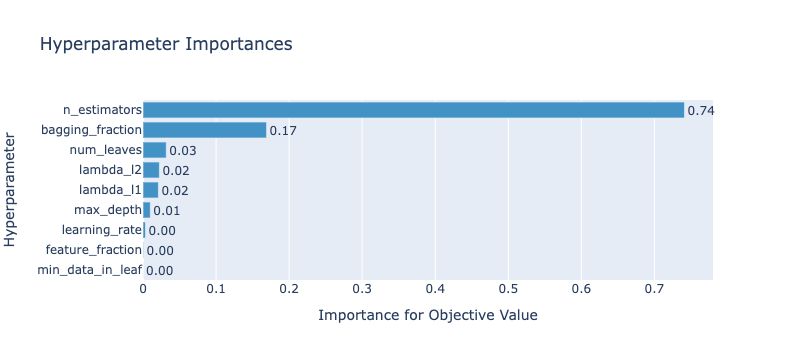

In [74]:
import optuna.visualization as ov

ov.plot_param_importances(hptune)

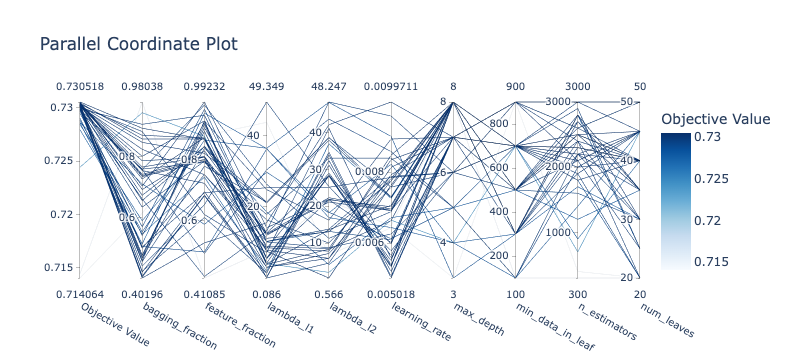

In [75]:
import optuna.visualization as ov

ov.plot_parallel_coordinate(hptune)

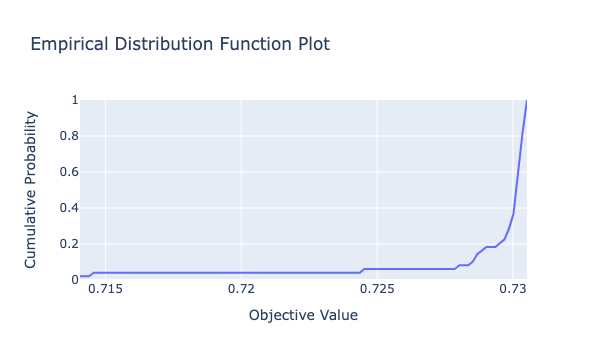

In [76]:
ov.plot_edf(hptune)

In [64]:
best_trials = hptune.best_trials.copy()
len(best_trials)

1

In [71]:
hptune.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_learning_rate,params_max_depth,params_min_data_in_leaf,params_n_estimators,params_num_leaves,state
0,0,0.729005,2021-11-10 17:58:37.463925,2021-11-10 18:01:18.689060,0 days 00:02:41.225135,0.505359,0.497059,36.205954,18.369821,0.006126,5,700,1800,20,COMPLETE
1,1,0.730101,2021-11-10 18:01:18.693064,2021-11-10 18:04:52.925030,0 days 00:03:34.231966,0.503920,0.692671,25.356939,25.148877,0.007848,6,900,2400,20,COMPLETE
2,2,0.729805,2021-11-10 18:04:52.930220,2021-11-10 18:07:50.506953,0 days 00:02:57.576733,0.757969,0.982293,26.341561,11.295934,0.006887,8,300,1900,20,COMPLETE
3,3,0.729617,2021-11-10 18:07:50.511838,2021-11-10 18:10:47.157237,0 days 00:02:56.645399,0.758240,0.491833,30.371464,43.622580,0.008576,5,100,2000,45,COMPLETE
4,4,0.729838,2021-11-10 18:10:47.162484,2021-11-10 18:14:39.836136,0 days 00:03:52.673652,0.661397,0.415876,13.231536,48.247392,0.009576,6,700,2900,25,COMPLETE
5,5,0.714064,2021-11-10 18:14:39.841091,2021-11-10 18:15:13.100088,0 days 00:00:33.258997,0.615069,0.880626,43.666859,6.773700,0.006432,3,900,400,20,COMPLETE
6,6,0.714471,2021-11-10 18:15:13.105550,2021-11-10 18:15:40.398658,0 days 00:00:27.293108,0.980376,0.410853,7.962743,21.506605,0.006487,8,100,300,20,COMPLETE
7,7,0.728406,2021-11-10 18:15:40.403984,2021-11-10 18:17:31.907657,0 days 00:01:51.503673,0.590048,0.846456,18.598387,4.193027,0.006715,5,500,1200,35,COMPLETE
8,8,0.729969,2021-11-10 18:17:31.912590,2021-11-10 18:20:35.392601,0 days 00:03:03.480011,0.634888,0.797116,17.853012,33.039479,0.008391,5,100,2200,30,COMPLETE
9,9,0.728601,2021-11-10 18:20:35.397732,2021-11-10 18:22:20.505136,0 days 00:01:45.107404,0.711114,0.587999,29.697714,18.221530,0.008222,4,100,1400,45,COMPLETE


#### Data Counts
---

#### Shap
---

In [83]:
woe_dict["p13_alj8120"]

,%accts,min,max,woe
0,35.06%,0.0,27.0,-0.2047
1,25.62%,28.0,96.0,-0.1365
2,3.68%,97.0,117.0,-0.1133
3,2.67%,118.0,133.0,-0.0704
4,4.24%,134.0,199.0,-0.0391
5,1.12%,200.0,362.0,0.0253
6,0.12%,363.0,806.0,0.2471
missing,27.49%,NaN,NaN,0.3438


In [85]:
woe_dict["p13_iqf9540"]

,%accts,min,max,woe
0,0.25%,0.0,2.0,1.3766
1,2.38%,3.0,36.0,1.2186
2,0.36%,37.0,44.0,1.1447
3,0.94%,45.0,67.0,1.0679
4,1.10%,68.0,101.0,0.9674
5,1.10%,102.0,141.0,0.9012
6,0.49%,142.0,161.0,0.8066
7,1.54%,162.0,231.0,0.7869
8,0.98%,232.0,281.0,0.7125
9,4.15%,282.0,560.0,0.6340


#### PDP
---

#### Risk Sensitivity
---